# Problem komiwojażera (TSP) — wprowadzenie

**Problem komiwojażera (TSP, z ang. Traveling Salesman Problem)** polega na znalezieniu najkrótszej możliwej trasy, która:

- rozpoczyna się w jednym z miast,
- odwiedza każde inne miasto dokładnie raz,
- i wraca do miasta początkowego.

To problem z dziedziny **optymalizacji kombinatorycznej** i należy do klasy problemów **NP-trudnych** – co oznacza, że dla dużych instancji nie da się go efektywnie rozwiązać metodą brute-force.

### 🔍 Cel:
Znaleźć jak najkrótszą trasę odwiedzającą wszystkie miasta dokładnie raz i wracającą do punktu startowego.

---

## Rozwiązanie z użyciem algorytmu genetycznego

Zamiast szukać idealnego rozwiązania, zastosujemy **algorytm genetyczny**, który symuluje proces ewolucji w przyrodzie.

### Główne etapy algorytmu:
1. **Populacja początkowa** – losowo wygenerowane możliwe trasy.
2. **Ocena osobników** – obliczenie długości każdej trasy.
3. **Selekcja** – wybór lepszych osobników do krzyżowania.
4. **Krzyżowanie (crossover)** – mieszanie tras dwóch rodziców.
5. **Mutacja** – wprowadzenie losowych zmian (dla różnorodności).
6. **Nowa populacja** – powtarzamy cykl przez wiele generacji.

Z każdą generacją populacja "uczy się", jak wygląda dobra trasa.

---

## Import funkcji

W tym notebooku używamy wcześniej zaimplementowanych funkcji z pliku `main.py`:


In [1]:
from main import *
from config import *
import pandas as pd
from dotenv import load_dotenv
import os
random.seed(SEED)

## Początkowe parametry (zapisane w tym formacie żeby jupyter i main korzystały z tych samych danych, także do testów)

In [2]:
params = {
    "Liczba miast (NUM_CITIES)": NUM_CITIES,
    "Rozmiar siatki (GRID_SIZE)": GRID_SIZE,
    "Wielkość populacji (POPULATION_COUNT)": POPULATION_COUNT,
    "Elita (BEST_COUNT)": BEST_COUNT,
    "Liczba generacji (GENERATIONS)": GENERATIONS,
    "Mutacja (MUTATION_RATE)": MUTATION_RATE,
    "Prawdopodobieństwo mutacji": INSERT_PROB,
    "Margines od krawędzi (DIST_FROM_BOUND)": DIST_FROM_BOUND,
    "Metoda selekcji (SELECTION_METHOD)": SELECTION_METHOD,
    "Seed (random)": SEED
}

df_config = pd.DataFrame(params.items(), columns=["Parametr", "Wartość"])
df_config

,Parametr,Wartość
0,Liczba miast (NUM_CITIES),40
1,Rozmiar siatki (GRID_SIZE),500
2,Wielkość populacji (POPULATION_COUNT),100
3,Elita (BEST_COUNT),20
4,Liczba generacji (GENERATIONS),1000
5,Mutacja (MUTATION_RATE),0.2
6,Prawdopodobieństwo mutacji,0.5
7,Margines od krawędzi (DIST_FROM_BOUND),30
8,Metoda selekcji (SELECTION_METHOD),tournament
9,Seed (random),123


## Wizualizacja wygenerowanych miast
### Wygenerujemy miasta losowo na siatce GRID_SIZE x GRID_SIZE i narysujemy je jako niebieskie kropki.

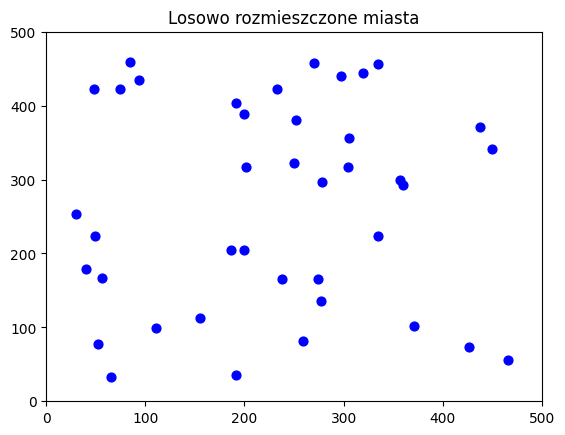

In [3]:
#Generowanie i wizualizacja miast
cities = generate_cities(NUM_CITIES,GRID_SIZE)
plt.scatter(*zip(*cities), c='blue', s=40)
plt.xlim(0, GRID_SIZE)
plt.ylim(0, GRID_SIZE)
plt.title("Losowo rozmieszczone miasta")
plt.show()

## Generowanie losowej trasy

Długość losowej trasy: 8922.96


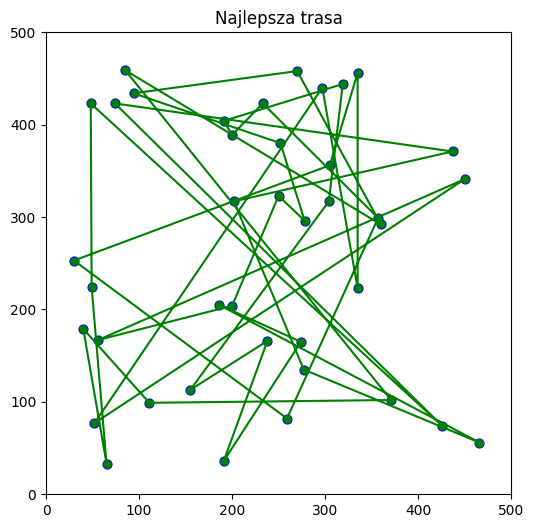

In [4]:
# Generowanie losowej trasy
random_path = list(range(NUM_CITIES))
random.shuffle(random_path)

# Wyświetlenie długości trasy
distance = evaluate_distance(random_path, cities)
print(f"Długość losowej trasy: {distance:.2f}")

# Rysowanie trasy
plot_route(random_path, cities)

### Jak widać trasa nie wydaje się być na pierwszy rzut oka optymalna, w tym celu wprowadzamy algotytmy genetyczne w celu znalezienia heurystycznie najlepszego rozwiązania
#### Zacznijmy od wygenerowania losowej populacji kolejności miast w jakich podróżujemy

In [4]:
population = generate_population(POPULATION_COUNT, NUM_CITIES)
# Szybki dataframe do wizuazalizacji genotypu
# Tworzymy DataFrame, gdzie każda trasa to jeden wiersz
df_population = pd.DataFrame(population)
df_population.index.name = "Indeks osobnika"
df_population.columns = [f"Miasto {i}" for i in range(NUM_CITIES)]

# Wyświetlamy tylko pierwsze 5 osobników, by nie zalać ekranu
df_population.head(5)

,Miasto 0,Miasto 1,Miasto 2,Miasto 3,Miasto 4,Miasto 5,Miasto 6,Miasto 7,Miasto 8,Miasto 9,...,Miasto 30,Miasto 31,Miasto 32,Miasto 33,Miasto 34,Miasto 35,Miasto 36,Miasto 37,Miasto 38,Miasto 39
Indeks osobnika,,,,,,,,,,,,,,,,,,,,,
0,26,23,32,2,11,5,31,16,10,33,...,21,15,4,25,13,1,37,9,28,7
1,24,29,2,0,8,38,12,1,16,25,...,32,18,10,15,28,5,22,7,9,4
2,22,1,10,26,4,9,23,15,5,36,...,6,18,0,31,13,3,7,14,33,25
3,19,27,1,10,33,20,35,32,8,36,...,12,39,13,25,21,4,14,26,9,5
4,21,35,34,8,37,36,30,31,25,24,...,6,20,28,1,17,2,9,13,14,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,24,35,27,15,37,39,36,34,29,12,...,8,16,1,9,10,14,17,5,30,31
96,16,36,14,9,1,19,23,34,6,30,...,28,3,35,4,31,27,12,38,32,33
97,19,24,27,1,18,16,23,6,12,31,...,28,9,25,7,36,3,21,0,2,39


### Teraz dla tej populacji znajdziemy najlepszych (ustawione na 20% całości populacji), można zmienić za pomocą `BEST_COUNT` obecnie to `BEST_COUNT = POPULATION_COUNT // 5`. Wyświetlimy najlepszego zawodnika i długość jego trasy.

Najlepszy osobnik (genotyp):
[24, 37, 29, 5, 12, 9, 32, 21, 39, 23, 2, 19, 35, 31, 33, 18, 10, 8, 7, 36, 34, 27, 16, 20, 15, 0, 11, 17, 28, 22, 25, 13, 14, 26, 6, 4, 3, 30, 38, 1]

Długość trasy najlepszego osobnika: 7990.90


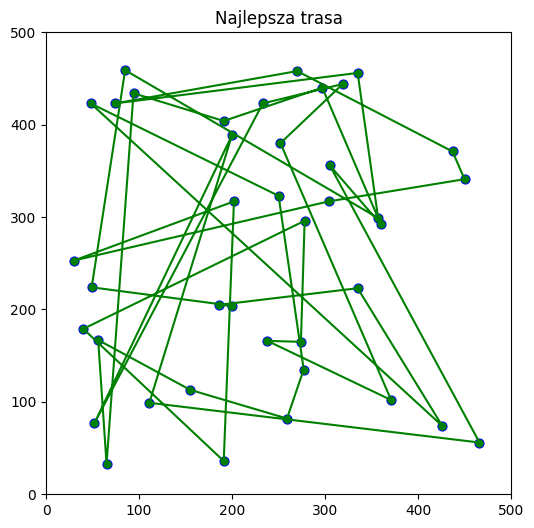

In [6]:
# Wybór najlepszych osobników (elitarnych)
best_individuals = select_best_individuals(population, cities, BEST_COUNT)

# Najlepszy osobnik (najkrótsza trasa)
best = best_individuals[0]
best_distance = evaluate_distance(best, cities)

print("Najlepszy osobnik (genotyp):")
print(best)
print(f"\nDługość trasy najlepszego osobnika: {best_distance:.2f}")


plot_route(best, cities)

### Trasa wydaje się być lepsza niż poprzednim wykresie, co udowadnia także długość trasy, która jest krótsza.
---

# 🔁 Wprowadzenie do algorytmu genetycznego (AG) w problemie TSP

W poprzednich krokach wygenerowaliśmy miasta, populację tras oraz znaleźliśmy najlepszego osobnika.  
Teraz pora przejść do **heurystycznego optymalizowania trasy** za pomocą **algorytmu genetycznego**.

AG to inspiracja biologiczną ewolucją — działa na populacji rozwiązań i stopniowo "ewoluuje" ją w stronę coraz lepszych wyników.

---

## 🧠 Kluczowe elementy algorytmu genetycznego:

### 1. **Selekcja rodziców**
Z populacji wybieramy osobniki, które będą miały "potomstwo":

- `roulette_selection(best_individuals, cities)`  
    Selekcja na podstawie koła ruletki — lepsze osobniki mają większą szansę na bycie wybrane.

- `tournament_selection(population, cities, k=3)`  
    Wybieramy losową grupkę osobników i wybieramy najlepszego z nich.

---

### 2. **Krzyżowanie**
Tworzymy nowego osobnika (trasę) na podstawie dwóch rodziców:

- `crossover_ox(parent1, parent2)`  
    Order Crossover (OX) — fragment jednego rodzica + kolejność zachowana z drugiego.

---

### 3. **Mutacja**
Wprowadzamy drobne zmiany w potomkach, by utrzymać różnorodność:

- `mutate_insert(individual)`  
    Wybieramy jeden gen i wstawiamy go w inne miejsce.

- `mutate_swap(individual)`  
    Zamieniamy dwa losowe miasta w trasie.

- `mutate(individual)`  
    Losowo wybiera między `insert` a `swap`. 50% szans

---

### 4. **Nowa populacja**
Tworzymy nową generację osobników:



In [7]:
population = create_new_population(
    best_individuals,
    population,
    cities,
    POPULATION_COUNT,
    insert_prob=INSERT_PROB,
    selection_method=SELECTION_METHOD
) #bazowo jest tournament selection

Najlepszy osobnik (genotyp):
[24, 37, 29, 5, 12, 9, 39, 23, 2, 35, 31, 10, 7, 36, 34, 27, 16, 20, 0, 11, 17, 28, 22, 25, 13, 14, 26, 30, 21, 18, 15, 8, 19, 33, 38, 32, 6, 4, 3, 1]

Długość trasy najlepszego osobnika: 7263.60


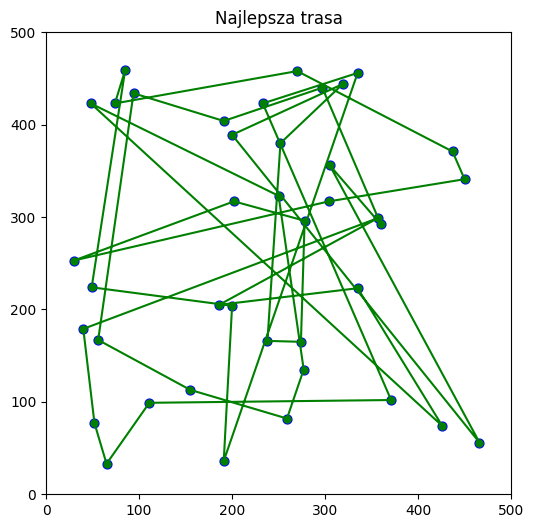

In [8]:
# Wybór najlepszych osobników (elitarnych)
best_individuals = select_best_individuals(population, cities, BEST_COUNT)

# Najlepszy osobnik (najkrótsza trasa)
best = best_individuals[0]
best_distance = evaluate_distance(best, cities)

print("Najlepszy osobnik (genotyp):")
print(best)
print(f"\nDługość trasy najlepszego osobnika: {best_distance:.2f}")

plot_route(best, cities)

## Kopiuj wklej z poprzedniej komórki wyboru najlepszego, już w pierwszej iteracji widzimy poprawę! Długość trasy znowu zmalała

---

# Wykonajmy teraz cały algorytm dla 1000 generacji i nowej mapy

Generacja 950 | Najlepszy dystans: 2770.38


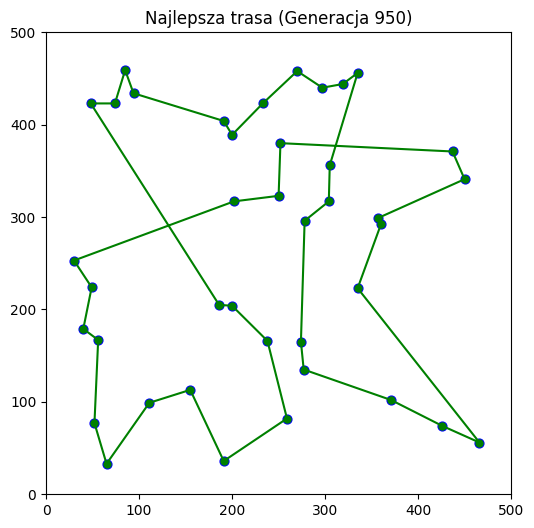

Najlepszy osobnik: [26, 25, 1, 3, 20, 16, 10, 33, 24, 27, 31, 38, 36, 5, 39, 23, 28, 19, 13, 7, 14, 34, 30, 29, 37, 35, 22, 9, 12, 4, 21, 0, 18, 15, 8, 11, 32, 17, 2, 6]
Długość trasy: 2770.3781071659632


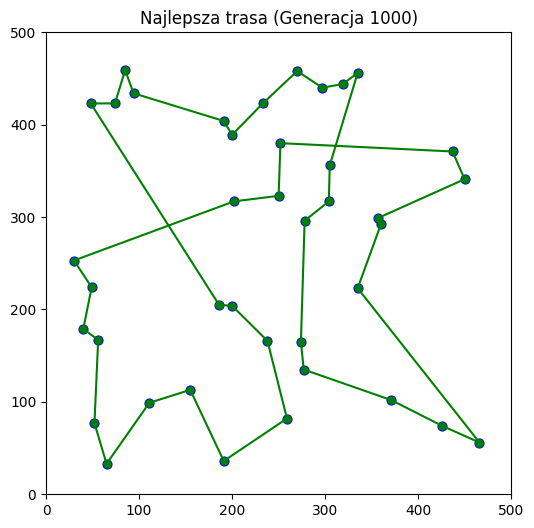

In [9]:
result = run_genetic_algorithm(show_progress=True)

# Więc znaleźliśmy *najprawdopodobniej* najlepsze rozwiązanie teraz zajmiemy się analizą wyników.

In [10]:
df_result = pd.DataFrame({
    "generation": range(len(result["best_distances"])),
    "best_distance": result["best_distances"],
    "avg_distance": result["avg_distances"]
})
df_result

,generation,best_distance,avg_distance
0,0,7990.899004,9596.458947
1,1,7582.594679,8669.623528
2,2,7161.663756,8110.734911
3,3,6805.253791,7765.379554
4,4,6376.991070,7362.328704
...,...,...,...
995,995,2770.378107,3128.818141
996,996,2770.378107,3106.430110
997,997,2770.378107,3084.378528
998,998,2770.378107,3080.511476


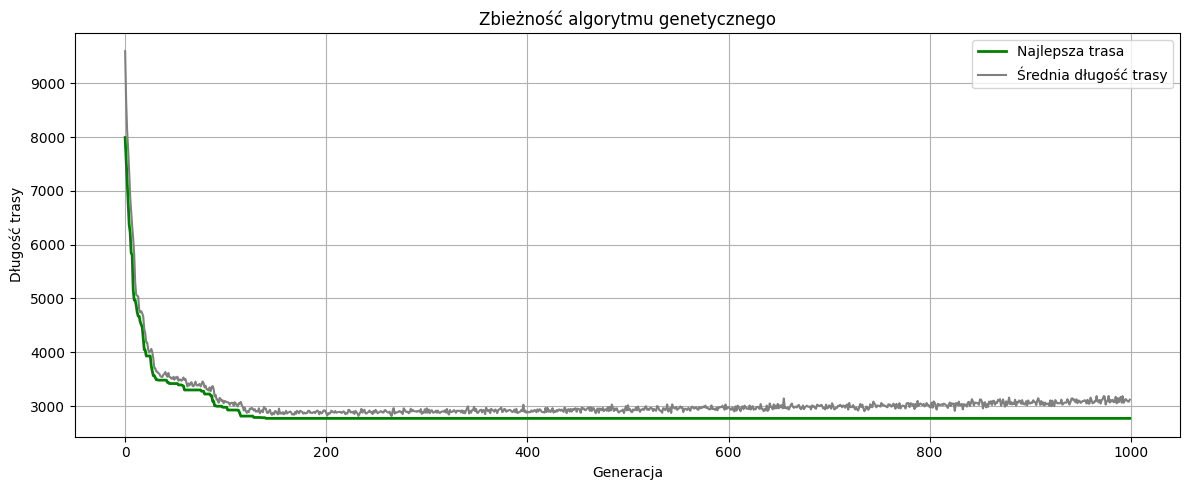

In [11]:
plt.figure(figsize=(12, 5))
plt.plot(df_result["generation"], df_result["best_distance"], label="Najlepsza trasa", color='green', linewidth=2)
plt.plot(df_result["generation"], df_result["avg_distance"], label="Średnia długość trasy", color='gray', linestyle='-')
plt.xlabel("Generacja")
plt.ylabel("Długość trasy")
plt.title("Zbieżność algorytmu genetycznego")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
result["final_mutation_rate"]

0.6118045725078122

## Średnia długość trasy rośnie

Na wykresie widać, że mimo tego, że najlepszy osobnik się poprawia (trasa się skraca),  
to **średnia długość tras w populacji rośnie**.

Dlaczego?

W każdej 100. generacji bez poprawy zwiększam `MUTATION_RATE`:

`MUTATION_RATE *= 1.15`

Więcej mutacji = większy chaos → większy rozrzut tras → wyższa średnia.

To efekt uboczny mechanizmu, którym próbuje pomóc algorytmowi wyjść z lokalnych minimów.

---

# Porównanie tournament z roulette

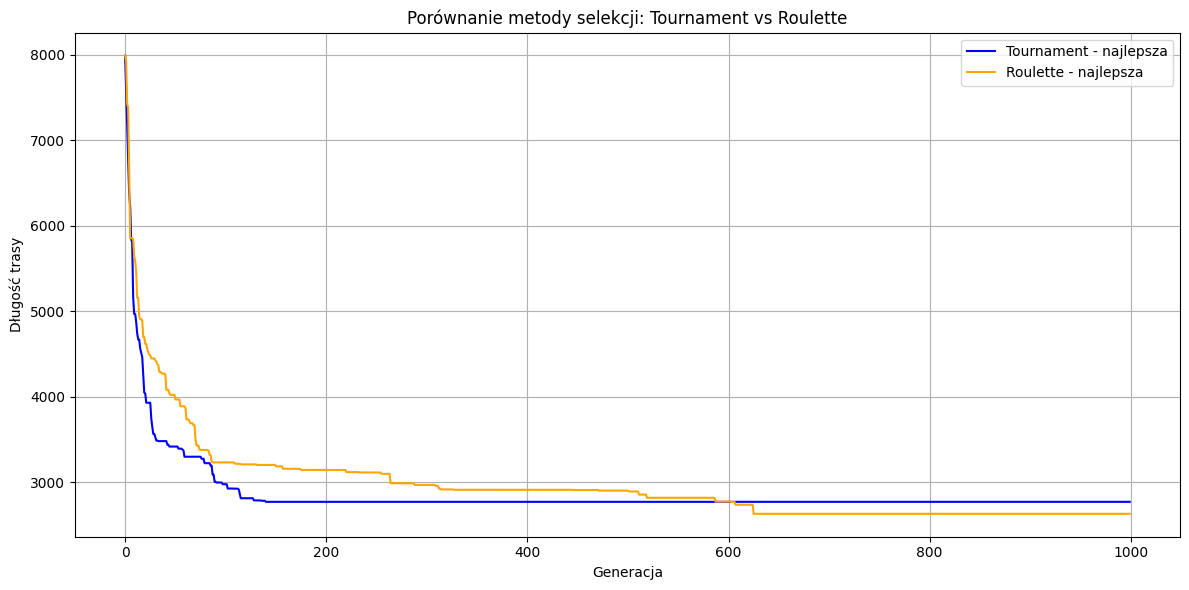

In [13]:
# Tournament
result_tournament = run_genetic_algorithm(selection_method="tournament")

df_tournament = pd.DataFrame({
    "generation": range(len(result_tournament["best_distances"])),
    "best_distance": result_tournament["best_distances"],
    "avg_distance": result_tournament["avg_distances"]
})

# Roulette
result_roulette = run_genetic_algorithm(selection_method="roulette")

df_roulette = pd.DataFrame({
    "generation": range(len(result_roulette["best_distances"])),
    "best_distance": result_roulette["best_distances"],
    "avg_distance": result_roulette["avg_distances"]
})

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df_tournament["generation"], df_tournament["best_distance"], label="Tournament - najlepsza", color='blue')
plt.plot(df_roulette["generation"], df_roulette["best_distance"], label="Roulette - najlepsza", color='orange')
plt.xlabel("Generacja")
plt.ylabel("Długość trasy")
plt.title("Porównanie metody selekcji: Tournament vs Roulette")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## ✅ Wnioski z porównania metod selekcji

- **Obie metody** skutecznie minimalizują długość trasy w pierwszych generacjach.
- **Tournament selection** szybciej schodzi do niższych wartości — krzywa jest ostrzejsza i szybciej się stabilizuje.
- **Roulette selection** działa wolniej — schodzi łagodniej i stabilizuje się później.
- Finalnie roulette osiąga **lepszy wynik końcowy** (niższa długość najlepszej trasy).
- Roulette daje większą różnorodność w populacji, ale kosztem precyzji w późniejszych generacjach.

🔎 Tournament selection jest bardziej eksploatująca (skupia się na najlepszych),
a roulette selection bardziej eksploruje (daje szanse też słabszym trasom), co może być przydatne przy trudniejszych problemach.

---

# Porównany *elite* naszej populacji (używając metody turniejowej)

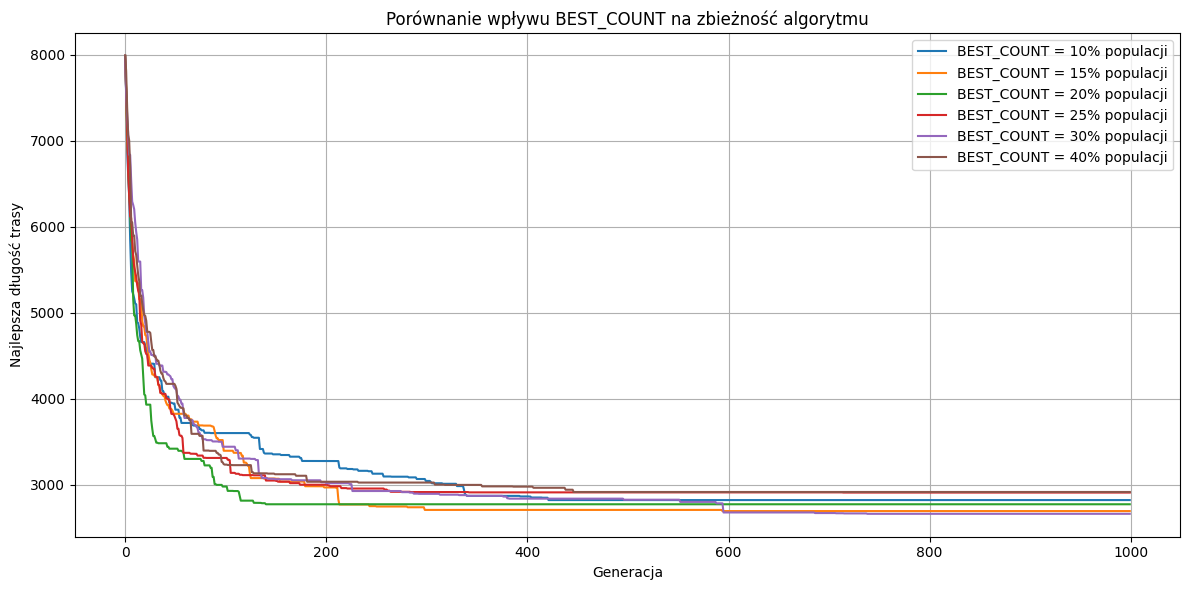

In [14]:
def run_with_best_count_ratio(ratio):
    best_count = int(POPULATION_COUNT * ratio)
    return run_genetic_algorithm(best_count=best_count)

ratios = [0.1, 0.15, 0.2, 0.25, 0.3, 0.4]
results = {}

for r in ratios:
    results[r] = run_with_best_count_ratio(r)

dfs = {}
for r in results:
    dfs[r] = pd.DataFrame({
        "generation": range(GENERATIONS),
        "best_distance": results[r]["best_distances"],
        "ratio": f"{int(r * 100)}%"
    })

df_combined = pd.concat(dfs.values(), ignore_index=True)

# Wykres porównawczy
plt.figure(figsize=(12, 6))
for r in ratios:
    label = f"BEST_COUNT = {int(r * 100)}% populacji"
    plt.plot(dfs[r]["generation"], dfs[r]["best_distance"], label=label)

plt.title("Porównanie wpływu BEST_COUNT na zbieżność algorytmu")
plt.xlabel("Generacja")
plt.ylabel("Najlepsza długość trasy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Można wysnuć wnioski, że wszystkie są podobne do siebie, ale 30% daje najlepsze wyniki więc przy tym zostaniemy.

---

# Mutacje

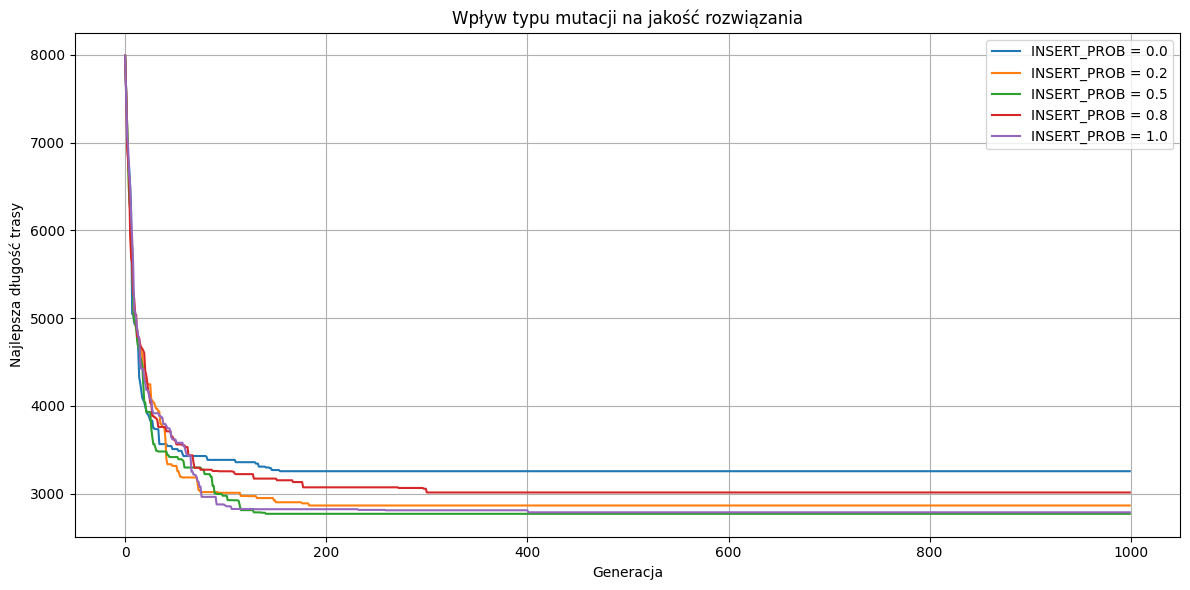

In [15]:
def run_with_insert_prob(p):
    return run_genetic_algorithm(insert_prob=p)

probs = [0.0, 0.25, 0.5, 0.75, 1.0]  # 0.0 = tylko swap, 1.0 = tylko insert
insert_results = {}

for p in probs:
    insert_results[p] = run_with_insert_prob(p)

# Tworzymy wykres porównujący różne typy mutacji
plt.figure(figsize=(12, 6))
for p in probs:
    label = f"INSERT_PROB = {p:.1f}"
    plt.plot(
        insert_results[p]["best_distances"],
        label=label
    )

plt.title("Wpływ typu mutacji na jakość rozwiązania")
plt.xlabel("Generacja")
plt.ylabel("Najlepsza długość trasy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Najlepsze wyniki daje 50% swap mutation do insert mutation! Zmieniamy parametry na które się dowiedzieliśmy, że są najlepsze

Generacja 950 | Najlepszy dystans: 2659.20


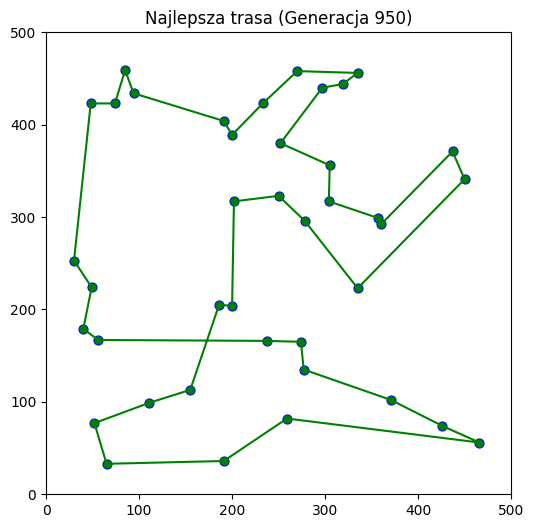

Najlepszy osobnik: [18, 15, 32, 17, 7, 13, 19, 28, 23, 2, 0, 21, 4, 12, 25, 1, 3, 20, 16, 10, 33, 24, 38, 31, 27, 35, 36, 5, 30, 34, 37, 29, 14, 39, 22, 9, 6, 26, 11, 8]
Długość trasy: 2659.1977349988883


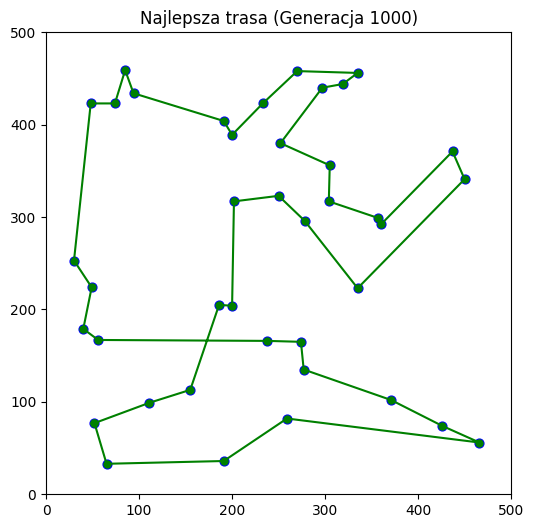

In [16]:
final_results = run_genetic_algorithm(selection_method="tournament", #wybieram tournament nad roulette ze wzgledu na dużo 
                                      best_count=int(POPULATION_COUNT * 0.3), # szybsze obliczenia, a podobne wyniki
                                      insert_prob=0.5,
                                      show_progress=True,)

## 📌 Podsumowanie

Wyniki są zależne od rozmieszczenia miast – inne ułożenie może dać inne rezultaty.

Dla aktualnych testów najlepsze efekty uzyskano przy:
- selekcji: **tournament**
- `INSERT_PROB = 0.5` (czyli 50% szansy na mutację typu insert)
- 30% populacji jest brane do krzyżowania turniejowego

Na koniec uruchamiamy algorytm z najlepszymi parametrami, dzięki czemu uzyskujemy lepszy wynik.

Inne wyniki mogłby być jeśli testowana byłaby metoda ruletki, inne procenty, wszystko trzebaby było ztestować ale to już i tak za długie chyba wyszło, więc na tym skończę

## 📊 Porównanie długości tras

- 🔹 **Losowa trasa:** 8922.96  
- 🔹 **Najlepszy osobnik z losowej populacji:** 7990.90  
- 🔹 **Najlepszy osobnik po pierwszym wyborze elity:** 7263.60  
- 🔹 **Trasa po 1000 generacjach z domyślnymi parametrami:** 2770.38  
- ✅ **Trasa po dostrojeniu parametrów:** 2659.20  

Oczywiście nie jest zagwarantowane, że jest to najlepsze rozwiązanie, ale tutaj mamy piękno heurystyki ;) 